### MNIST 99.8%

Here we describe our experiment with the venerable MNIST dataset of hand-written digits.

* We reliably get a classification accuracy of about 99.8 percent on the ten thousand test images, after training on the sixty-thousand training images.  This is with a committee of 5 neural net classifiers.  Single-net classification accuracy is usually in the mid 99.7 to 99.8 range.

* On the free Colab GPU instance, presently each net trains in about six minutes, with only ten presentations of the training set (ten epochs).

* Along with this notebook, we release the source code of our system, written in Python using PyTorch, so others can reproduce or use our results.

### Set up

In [77]:
# Add this package to Colab
!pip install Augmentor

In [0]:
# Utility code for this notebook.
!wget --quiet https://github.com/ttdoucet/mnist/raw/master/mnist.py -O mnist.py

In [79]:
# Let's see what they are giving us.
!nvidia-smi

Mon Feb 24 06:17:43 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    31W / 250W |  10383MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Data

In [0]:
from mnist import *
trainset = mnist_trainset(heldout=0)
testset = mnist_testset()

Our training dataset includes on-the-fly augmentation.
Each time an image is retrieved, it is randomly cropped
to move it around a little, and also subjected to a small amount
of random rotation, and then a small amount of elastic distortion
is applied.

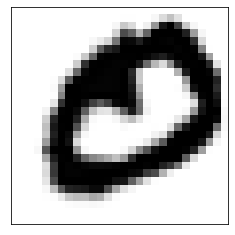

In [81]:
# Here we take the first image in the train dataset and display it
# To see the effect of the augmentation, you can simply refresh this
# cell repeatedly with Ctrl-Enter.
image, label = trainset[0]
show_image(image, interpolation='nearest')

In [0]:
# We set up to retrieve batches at a time.
batcher = Batcher(trainset, bs=144)

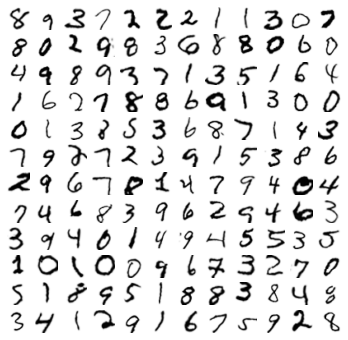

In [83]:
# Display a batch of (augmented) images.  You can refresh 
# this cell with Ctrl-Enter to see additional batches.
images, labels = next(batcher)
plot_images(images)

### Model

Below is the model we use for the MNIST classifier, expressed in PyTorch.

* It is a fairly conventional multilayer convolutional neural net 
with some Resnet-like elements.
* The Residual blocks are ordinary 3x3 convolutions with a shortcut connection going around.
* It makes heavy use of batchnorm, perhaps to a fault.
* It uses old-school maxpool instead of strided convolutions, but we haven't tried the latter.
* It has 7 convolutional layers, including the Residual blocks, which end with 512 4x4 activations.
* These are averaged into a vector of 512 activations, and then a single small dense layer converts those to ten logits output.

In [0]:
class Residual(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.bn = nn.BatchNorm2d(d)
        self.conv3x3 = nn.Conv2d(in_channels=d, out_channels=d,
                                 kernel_size=3, padding=1)

    def forward(self, x):
        x = self.bn(x)
        return x + F.relu(self.conv3x3(x))

def _mnist_model():
    "Returns an initialized but untrained model for MNIST."
    return nn.Sequential(
               nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5, padding=2),
               nn.ReLU(),

               Residual(128),
               nn.MaxPool2d(2),
               Residual(128),

               nn.BatchNorm2d(128),
               nn.Conv2d(128, 256, 3, padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2),
               Residual(256),

               nn.BatchNorm2d(256),
               nn.Conv2d(256, 512, 3, padding=1),
               nn.ReLU(),
               nn.MaxPool2d(2, ceil_mode=True),
               Residual(512),

               nn.BatchNorm2d(512),
               nn.AvgPool2d(kernel_size=4),
               Flatten(),

               nn.Linear(512,10),
               # Softmax provided during training.
           )

### Training

We do a learning rate sweep (like the one used in the fastai library) and plot the learning rate vs the training loss.

stopping at step 390


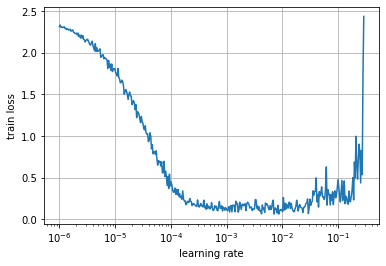

In [85]:
batchsize = 200
trainer = Trainer(mnist_model(), trainset, mnist_testset(augmented=True))
lr_find(trainer, p=0.90, wd=0, bs=batchsize);

Based on this, we choose a maximum learning rate of `4e-4`, which is about as high as we can go before the curve flattens out and eventually becomes bumpy.

We somewhat arbitrarily choose a factor of `10` and let the learning rate vary between `4e-4` and `4e-5`.  We use a conventional exponentially-falling learning rate schedule, starting at the maximum and ending at the minimum.  We set the momentum to 0.9 and leave it there.

Finally, at the end we train for one additional epoch and rapidly annihilate ("towards nothing") the learning rate by several orders of magnitude.

In [0]:
def annihilate(cb, epochs=1):
    "Quickly reduce learning rate towards zero."
    lr_start = cb.lrs[-1]
    batches = epochs_to_batches(cb.trainer.train_set, epochs, cb.bs)
    lr = cos_interpolator(lr_start, lr_start/1e3, batches)
    return cb.trainer.train(lr=lr, p=cb.moms[-1], wd=cb.wd, epochs=epochs, bs=cb.bs, callback=cb)

def train_one(trainset, testset, callback=None):
    "Train MNIST model according to desired parameters and schedule."
    epochs, lr_max, bs, wd = (10, 4e-4, batchsize, 0.0)

    model = mnist_model()
    trainer = Trainer(model, trainset)
    lr = exp_interpolator(lr_max, lr_max/10, epochs_to_batches(trainset, epochs, bs))
    
    cb = None if callback is None else callback(trainer)
    cb = trainer.train(lr, p=0.90, epochs=epochs, bs=bs, wd=wd, callback=cb)
    cb = annihilate(cb)

    acc, lss = accuracy(Classifier(model), ds=testset, include_loss=True)
    print(f"test set: loss = {lss:.3g}, accuracy = {percent(acc)}")
 
    return model, cb


In [87]:
m1, cb = train_one(trainset, testset)

test set: loss = 0.00864, accuracy = 99.73%


This net trains in several minutes, depending on
the GPU assigned, and the
single-net performance is typically near the top of the systems listed on Yann LeCun's
MNIST page (see References).

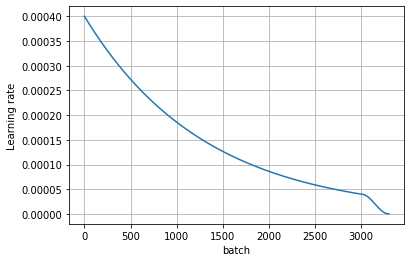

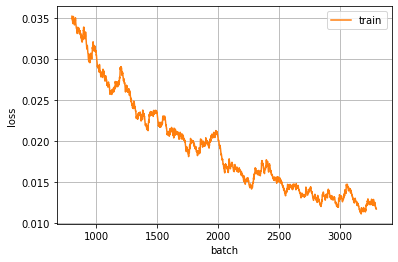

In [88]:
# The callback value returned, cb, holds a history of the training
# session, including the learning rates used during training and the
# training loss at each batch.  (If we give trainer.train() a
# ValidationCallback parameter, it will additionally collect validation
# loss and other data.)
cb.plot_lr()
cb.plot_loss(start=800, halflife=60)

In [89]:
# Let's train four more.
m2, cb2 = train_one(trainset, testset)
m3, cb3 = train_one(trainset, testset)
m4, cb4 = train_one(trainset, testset)
m5, cb5 = train_one(trainset, testset)

test set: loss = 0.00913, accuracy = 99.71%


test set: loss = 0.00756, accuracy = 99.77%


test set: loss = 0.00831, accuracy = 99.69%


test set: loss = 0.00888, accuracy = 99.71%


In [92]:
# And five more.
m6, cb6 = train_one(trainset, testset)
m7, cb7 = train_one(trainset, testset)
m8, cb8 = train_one(trainset, testset)
m9, cb9 = train_one(trainset, testset)
m10, c10 = train_one(trainset, testset)

test set: loss = 0.00777, accuracy = 99.77%


test set: loss = 0.00808, accuracy = 99.74%


test set: loss = 0.00811, accuracy = 99.68%


test set: loss = 0.00905, accuracy = 99.66%


test set: loss = 0.00841, accuracy = 99.72%


In [93]:
# Wrap each of the trained models into a Classifier object.
classifiers = [Classifier(m) for m in [m1, m2, m3, m4, m5, m6, m7, m8, m9, m10]]
# And combine those classifiers into a committee classifier.
voter = VotingClassifier(classifiers)

# Let's see how it does!
acc = accuracy(voter, ds=testset)
print(f"Committee of {len(classifiers)} accuracy: {percent(acc)}")

Committee of 10 accuracy: 99.78%


For a committee of ten, we typically see around 99.8 percent, which is better than the best listed on Yann LeCun's MNIST page (last updated circa 2012).

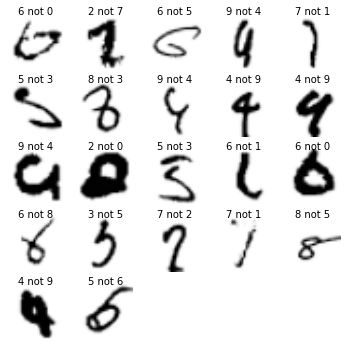

In [94]:
# Let's see the items in the test set that our committee-of-ten got wrong.
show_mistakes(voter, testset);

### Thoughts

We are pleased to discover that it is possible to get very good results on MNIST using fast training of neural nets--ten epochs of training plus one epoch to annihilate the learning rate.  These single nets are near the top of what has been published, and when combined into committees they significantly exceed prior results published on the MNIST site or elsewhere (that we know of).

For regularization, we rely on batchnorm and, probably, the fact that we do not train for very long.  Adding dropout to the small dense layer at the end seemed to have little or no effect.

We do not use any weight decay.  We implemented weight decay independent of the Adam optimizer's version (which we set to zero) and tried various amounts.  Zero seemed about right, perhaps because we are not training for very long and the weights do not rise very much anyway.  It is possible that a small amount of weight decay would be appropriate even for our quick training, but we have not found it yet.

The data augmentation made a significant difference, taking our single-net performance from the 99.60's to 99.70's range.  We suspect that this works primarily by keeping the network from overfitting to the one-hot labels and training images too quickly (as opposed to, for example, learning more robust representations).

Interestingly, the network never sees the unaugmented data during training.  Yet experiments indicate that it is still starting to "overfit" on this data that it has never seen at the end of training--it classifies the unaugmented training data (which it has never seen) better than the next epoch of augmented training data.

Consistent with this, at the end of our ten epochs of training, we have not yet reached perfect accuracy on the training set.  We are certainly doing "early stopping" by an indirect means, and this is part of why we think the data augmentation has more to do with "early stopping" than it has to do with robust representations.

Todd Doucet  
Pittsburgh, January 31, 2019  
(updated for Google Colab February 2020)


### References

> Jeremy Howard's [**fast.ai site**](https://www.fast.ai)
and [**fastai library**](https://github.com/fastai/fastai)  
The code we wrote is all in native PyTorch, but many of the
ideas and some of the style is inspired by the new fastai 1.0
library.  We think the library is wonderful, and Jeremy's courses
are a treasure.  The only reason we didn't use fastai directly is that it was just too much fun to write what we needed.  Also, this was an exercise in learning PyTorch.

> Yann LeCun's [**MNIST page**](http://yann.lecun.com/exdb/mnist/)  
It looks like the results have not been updated since about 2012.  So we do not claim that our result is the best out there, only that we think we have a good and interesting result.

> [**Regularization of neural networks using DropConnect**](https://cs.nyu.edu/~wanli/dropc/dropc.pdf)  
Li Wan, Matthew Zeiler, Sixin Zhang, Yann LeCun, and Rob Fergus  
This paper's focus is not on MNIST, but they get a better
result on MNIST than the best result on Yann LeCun's site.  (But not
as good as the result we get here, and they use many more epochs in
training.)